In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib
from sklearn.preprocessing import RobustScaler

In [2]:
df2 = pd.read_excel("../markaFile/Mercedes.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_190,Seri_200,Seri_220,...,Model_SE,Model_SEL,Model_TD,Model_TE,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,1450000,2015,211,1991,125000,NaN,NaN,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,145000,1987,123,1997,400100,12.0,0.0,1,0,0,...,0,0,0,0,0,0,1,1,0,0
2,1450000,2015,156,1595,114000,0.0,0.0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,1380000,2016,136,1598,190342,3.0,2.0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,1175000,2013,156,1595,192000,2.0,0.0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_7948\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,553138.577174,5.834889e+11,763864.450309,213180.843602


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-10-08 14:16:26,264] A new study created in memory with name: no-name-50edd6a6-f0b5-4bbb-b1b5-4967b3d02e43
[I 2023-10-08 14:16:26,798] Trial 7 finished with value: 2163066.7939263387 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.07555224396602532, 'max_depth': 7, 'min_child_weight': 296}. Best is trial 7 with value: 2163066.7939263387.
[I 2023-10-08 14:16:26,842] Trial 3 finished with value: 2614298.9731207937 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.00010530818711914624, 'max_depth': 8, 'min_child_weight': 254}. Best is trial 7 with value: 2163066.7939263387.
[I 2023-10-08 14:16:26,842] Trial 5 finished with value: 2612390.7540248074 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.00028087605017236225, 'max_depth': 6, 'min_child_weight': 260}. Best is trial 7 with value: 2163066.7939263387.
[I 2023-10-08 14:16:26,918] Trial 0 finished with value: 1954896.2976617513 and paramete

[I 2023-10-08 14:16:29,519] Trial 30 finished with value: 1926384.004575316 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.042679179761706466, 'max_depth': 3, 'min_child_weight': 9}. Best is trial 17 with value: 836279.7236886626.
[I 2023-10-08 14:16:29,570] Trial 31 finished with value: 1912935.957839794 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.040313800627547386, 'max_depth': 4, 'min_child_weight': 2}. Best is trial 17 with value: 836279.7236886626.
[I 2023-10-08 14:16:29,816] Trial 32 finished with value: 1907631.8734442324 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.04656633876694932, 'max_depth': 3, 'min_child_weight': 26}. Best is trial 17 with value: 836279.7236886626.
[I 2023-10-08 14:16:30,056] Trial 35 finished with value: 1288720.5316412288 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.2842002002667718, 'max_depth': 13, 'min_child_weight':

[I 2023-10-08 14:16:33,010] Trial 60 finished with value: 1609007.5110213703 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.38397318598435237, 'max_depth': 12, 'min_child_weight': 112}. Best is trial 17 with value: 836279.7236886626.
[I 2023-10-08 14:16:33,111] Trial 62 finished with value: 1567507.0469909501 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.3454109749600971, 'max_depth': 8, 'min_child_weight': 101}. Best is trial 17 with value: 836279.7236886626.
[I 2023-10-08 14:16:33,170] Trial 61 finished with value: 896938.4031346278 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.48075143688731153, 'max_depth': 12, 'min_child_weight': 17}. Best is trial 17 with value: 836279.7236886626.
[I 2023-10-08 14:16:33,361] Trial 63 finished with value: 1558731.5948459392 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.35944722773734394, 'max_depth': 8, 'min_child_weig

[I 2023-10-08 14:16:36,461] Trial 90 finished with value: 844651.8375136454 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.2891991163209165, 'max_depth': 12, 'min_child_weight': 3}. Best is trial 89 with value: 789198.6494082835.
[I 2023-10-08 14:16:36,547] Trial 91 finished with value: 944490.9452026164 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.3006337717890189, 'max_depth': 12, 'min_child_weight': 23}. Best is trial 89 with value: 789198.6494082835.
[I 2023-10-08 14:16:36,678] Trial 92 finished with value: 816466.2872219663 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.28807093121273414, 'max_depth': 12, 'min_child_weight': 2}. Best is trial 89 with value: 789198.6494082835.
[I 2023-10-08 14:16:36,764] Trial 93 finished with value: 927964.6534274283 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.3034215159365072, 'max_depth': 12, 'min_child_weight': 2}

[I 2023-10-08 14:16:40,203] Trial 120 finished with value: 787163.2606675245 and parameters: {'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3599849883953455, 'max_depth': 8, 'min_child_weight': 24}. Best is trial 99 with value: 765732.7227568303.
[I 2023-10-08 14:16:40,253] Trial 121 finished with value: 1101441.5437805983 and parameters: {'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.1577224098050002, 'max_depth': 8, 'min_child_weight': 28}. Best is trial 99 with value: 765732.7227568303.
[I 2023-10-08 14:16:40,387] Trial 122 finished with value: 1096762.2705761818 and parameters: {'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.15651325240146616, 'max_depth': 8, 'min_child_weight': 27}. Best is trial 99 with value: 765732.7227568303.
[I 2023-10-08 14:16:40,425] Trial 123 finished with value: 1095164.9140522943 and parameters: {'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.15989263129160222, 'max_depth': 8, 'min_child_weigh

[I 2023-10-08 14:16:43,910] Trial 148 finished with value: 851747.2426420919 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.4136957238492621, 'max_depth': 9, 'min_child_weight': 16}. Best is trial 132 with value: 764184.5875079908.
[I 2023-10-08 14:16:43,953] Trial 152 finished with value: 1543350.3914751185 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.33206315604524633, 'max_depth': 9, 'min_child_weight': 184}. Best is trial 132 with value: 764184.5875079908.
[I 2023-10-08 14:16:43,968] Trial 153 finished with value: 784929.856664685 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.3257564785915318, 'max_depth': 9, 'min_child_weight': 16}. Best is trial 132 with value: 764184.5875079908.
[I 2023-10-08 14:16:44,000] Trial 151 finished with value: 829169.6838380443 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.40048425075486016, 'max_depth': 9, 'min_child_weig

[I 2023-10-08 14:16:48,010] Trial 180 finished with value: 1009100.7501772643 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.19544468907036522, 'max_depth': 11, 'min_child_weight': 28}. Best is trial 132 with value: 764184.5875079908.
[I 2023-10-08 14:16:48,010] Trial 179 finished with value: 902560.7429485247 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.2001592614059929, 'max_depth': 11, 'min_child_weight': 8}. Best is trial 132 with value: 764184.5875079908.
[I 2023-10-08 14:16:48,029] Trial 181 finished with value: 991766.289231387 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.20574953565211374, 'max_depth': 11, 'min_child_weight': 28}. Best is trial 132 with value: 764184.5875079908.
[I 2023-10-08 14:16:48,084] Trial 183 finished with value: 779734.5245465575 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.3947348044182404, 'max_depth': 11, 'min_child_we

[I 2023-10-08 14:16:52,066] Trial 210 finished with value: 846428.2108961295 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.45834491557924056, 'max_depth': 9, 'min_child_weight': 31}. Best is trial 132 with value: 764184.5875079908.
[I 2023-10-08 14:16:52,090] Trial 211 finished with value: 843034.4022944106 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.448696235358061, 'max_depth': 9, 'min_child_weight': 31}. Best is trial 132 with value: 764184.5875079908.
[I 2023-10-08 14:16:52,263] Trial 215 finished with value: 1231482.7243803188 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.49390667328449306, 'max_depth': 12, 'min_child_weight': 45}. Best is trial 132 with value: 764184.5875079908.
[I 2023-10-08 14:16:52,362] Trial 213 finished with value: 926927.5148917295 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.4572579366412584, 'max_depth': 12, 'min_child_wei

[I 2023-10-08 14:16:56,238] Trial 239 finished with value: 833447.5205853302 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.29392959800964213, 'max_depth': 9, 'min_child_weight': 8}. Best is trial 132 with value: 764184.5875079908.
[I 2023-10-08 14:16:56,310] Trial 241 finished with value: 886893.1106442423 and parameters: {'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3065062486606902, 'max_depth': 13, 'min_child_weight': 6}. Best is trial 132 with value: 764184.5875079908.
[I 2023-10-08 14:16:56,478] Trial 242 finished with value: 812014.7926632465 and parameters: {'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.30208237585316206, 'max_depth': 13, 'min_child_weight': 27}. Best is trial 132 with value: 764184.5875079908.
[I 2023-10-08 14:16:56,566] Trial 243 finished with value: 808373.4847453252 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.30410770091856565, 'max_depth': 7, 'min_child_weig

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 742460.3325
Best params:
	colsample_bytree: 1.0
	subsample: 1.0
	learning_rate: 0.3253215963982823
	max_depth: 7
	min_child_weight: 27


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)


final_model = model.set_params(**study.best_params).fit(X_train,y_train)
    
cv_results = cross_validate(final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
    
y_pred = final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

{'TestDeger': 722610.0616732357, 'MSE': 645386383169.5045, 'RMSE': 803359.4358501707, 'MAE': 258240.52660939968}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.8625137718904337

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.8200978078991845

In [16]:
marka_model = joblib.dump(final_model, "Mercedes.pkl")

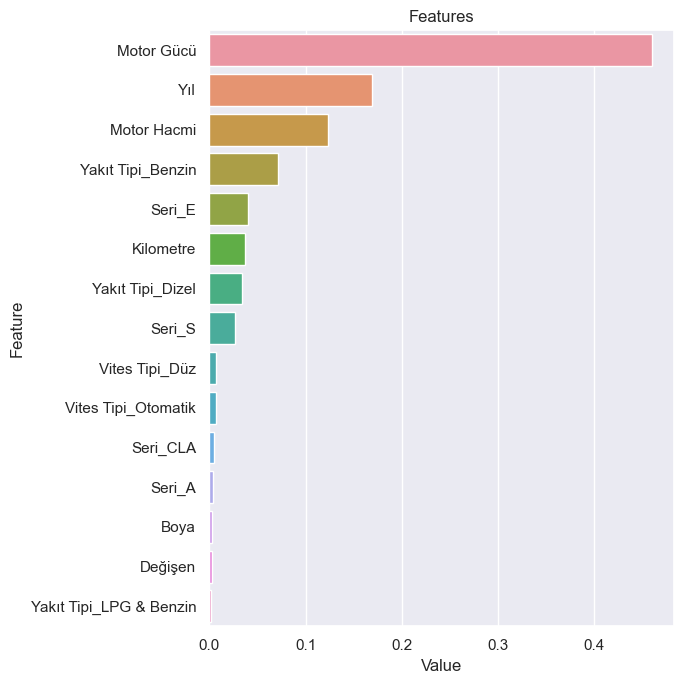

In [17]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(final_model,X)